# Import Libraries

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd


# Generate stock data

In [11]:
# Generate simple stock data
np.random.seed(42)
n_samples = 1000
n_timesteps = 50

# Simulate stock prices
def generate_stock_data(n_samples, n_timesteps):
    data = []
    labels = []
    for _ in range(n_samples):
        trend = np.random.choice([-1, 1])  # Upward (+1) or downward (-1) trend
        noise = np.random.normal(0, 0.5, n_timesteps)
        base = np.linspace(0, 10, n_timesteps) if trend == 1 else np.linspace(10, 0, n_timesteps)
        series = base + noise
        data.append(series)
        labels.append(1 if trend == 1 else 0)  # 1 for uptrend, 0 for downtrend
    return np.array(data), np.array(labels)

X, y = generate_stock_data(n_samples, n_timesteps)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Convert to PyTorch tensors
X_train, X_test = torch.tensor(X_train, dtype=torch.float32), torch.tensor(X_test, dtype=torch.float32)
y_train, y_test = torch.tensor(y_train, dtype=torch.long), torch.tensor(y_test, dtype=torch.long)


In [12]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create datasets
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

# Data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# Create Model

In [13]:
class LSTMCNNClassifier(nn.Module):
    def __init__(self, input_size, lstm_hidden_size, num_classes):
        super(LSTMCNNClassifier, self).__init__()
        self.lstm = nn.LSTM(input_size, lstm_hidden_size, batch_first=True)
        self.conv1d = nn.Conv1d(lstm_hidden_size, 32, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(32, num_classes)

    def forward(self, x):
        # LSTM
        lstm_out, _ = self.lstm(x)  # (batch_size, seq_length, lstm_hidden_size)

        # Transpose for Conv1d: (batch_size, lstm_hidden_size, seq_length)
        lstm_out = lstm_out.transpose(1, 2)

        # CNN
        conv_out = self.conv1d(lstm_out)  # (batch_size, 32, seq_length)
        conv_out = self.relu(conv_out)

        # Global average pooling to reduce sequence dimension
        conv_out = conv_out.mean(dim=2)  # (batch_size, 32)

        # Fully connected
        output = self.fc(conv_out)  # (batch_size, num_classes)
        return output


#   Train the model

In [14]:
# Model, loss function, and optimizer
input_size = 1
lstm_hidden_size = 64
num_classes = 2

model = LSTMCNNClassifier(input_size, lstm_hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 10
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        # Add channel dimension for LSTM
        X_batch = X_batch.unsqueeze(2)  # (batch_size, seq_length, input_size)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(train_loader):.4f}")


Epoch 1/10, Loss: 0.6886
Epoch 2/10, Loss: 0.4939
Epoch 3/10, Loss: 0.0059
Epoch 4/10, Loss: 0.0001
Epoch 5/10, Loss: 0.0000
Epoch 6/10, Loss: 0.0000
Epoch 7/10, Loss: 0.0000
Epoch 8/10, Loss: 0.0000
Epoch 9/10, Loss: 0.0000
Epoch 10/10, Loss: 0.0000


In [15]:
# Evaluate on test data
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.unsqueeze(2)  # (batch_size, seq_length, input_size)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(y_batch.numpy())
        y_pred.extend(predicted.numpy())

# Metrics
print("Classification Report:")
print(classification_report(y_true, y_pred))
print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        98
           1       1.00      1.00      1.00       102

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200

Accuracy: 1.0000


# Visualize the results

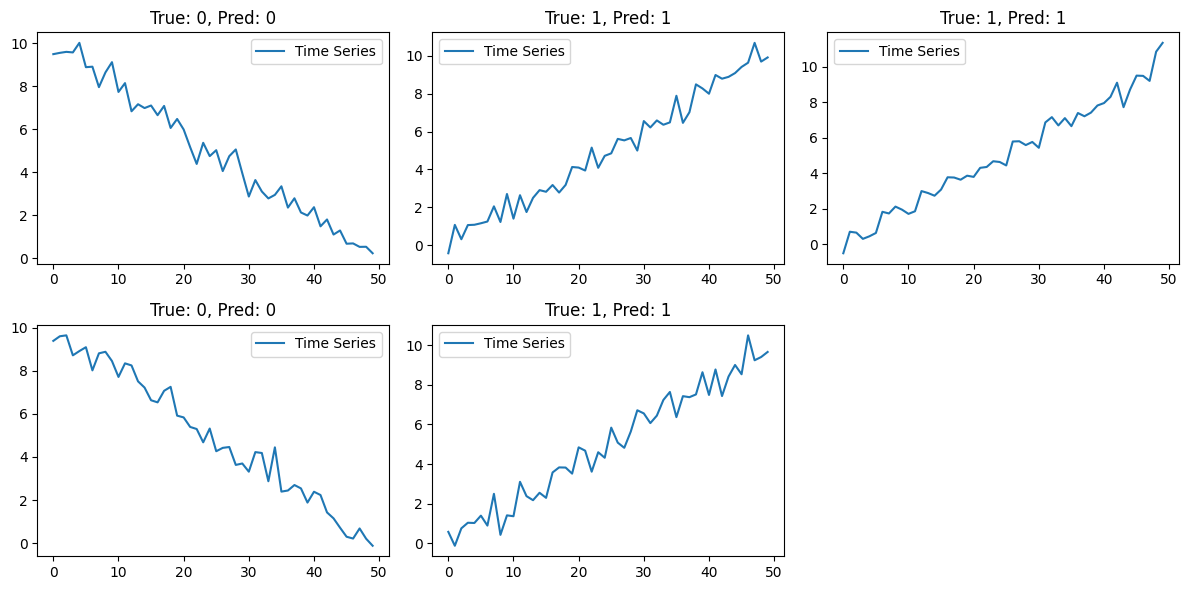

In [16]:
# Visualize a few test samples and predictions
plt.figure(figsize=(12, 6))
for i in range(5):
    idx = np.random.randint(0, len(X_test))
    sample = X_test[idx].numpy()
    label = y_test[idx].item()
    prediction = y_pred[idx]

    plt.subplot(2, 3, i+1)
    plt.plot(sample, label='Time Series')
    plt.title(f"True: {label}, Pred: {prediction}")
    plt.legend()
plt.tight_layout()
plt.show()
